In [1]:
# Below are the important libraries required to import and work on the analysis and modeling.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
warnings.filterwarnings('ignore')

# # Helper function with dataset download on the go!
# filename = "listings-data.csv"

# def getDataset(filename, **kwargs):
#     url = f"https://raw.githubusercontent.com/azizzoaib786/airbnb-dataset-prediction-miltiple-algo/main/{filename}"
#     try:
#         if filename not in os.listdir():
#             # Install wget if not already installed
#             try:
#                 import wget
#             except ImportError:
#                 !pip install wget
#                 import wget

#             # Download the file
#             wget.download(url, filename)
#             print(f"\n{filename} file downloaded successfully.")
#         else:
#             print(f"{filename} already exists.")
#         return pd.read_csv(filename, **kwargs)
#     except Exception as e:
#         print(e)
#         return pd.read_csv(url, **kwargs)

# data = getDataset(filename, encoding="unicode_escape")

# Load the data
data = pd.read_csv('listings-data.csv')

# Data Pre-Processing

### Check the quality of the data, check for null values and drop unneccary columns

In [2]:
# Use the head() function to check the column names.
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,92644,https://www.airbnb.com/rooms/92644,20230906022807,2023-09-06,city scrape,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,NaN,https://a0.muscache.com/pictures/715127/85bdb4...,498201,...,4.67,4.53,4.68,NaN,t,1,0,1,0,1.45
1,93015,https://www.airbnb.com/rooms/93015,20230906022807,2023-09-06,city scrape,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,Gorgeous 2 bed ground floor apartment with per...,A bit of history about the W14 area: <br />Com...,https://a0.muscache.com/pictures/865937ec-ee56...,499704,...,4.88,4.85,4.74,NaN,f,1,1,0,0,0.27
2,13913,https://www.airbnb.com/rooms/13913,20230906022807,2023-09-06,city scrape,Rental unit in Islington · ★4.80 · 1 bedroom ·...,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,...,4.82,4.69,4.69,NaN,f,2,1,1,0,0.26
3,15400,https://www.airbnb.com/rooms/15400,20230906022807,2023-09-06,city scrape,Rental unit in London · ★4.80 · 1 bedroom · 1 ...,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,...,4.83,4.93,4.74,NaN,f,1,1,0,0,0.56
4,93734,https://www.airbnb.com/rooms/93734,20230906022807,2023-09-07,city scrape,Condo in London · ★4.62 · 1 bedroom · 1 bed · ...,<b>During your stay</b><br />I’m a professiona...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,497514,...,4.81,4.64,4.67,NaN,f,1,0,1,0,1.21


In [3]:
# Using the info() function to check the summary of the data.
data.info()

# From the below summary we can see that some of the column names does not have the data, so we can safely remove them from the dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87946 entries, 0 to 87945
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            87946 non-null  int64  
 1   listing_url                                   87946 non-null  object 
 2   scrape_id                                     87946 non-null  int64  
 3   last_scraped                                  87946 non-null  object 
 4   source                                        87946 non-null  object 
 5   name                                          87946 non-null  object 
 6   description                                   86679 non-null  object 
 7   neighborhood_overview                         47190 non-null  object 
 8   picture_url                                   87943 non-null  object 
 9   host_id                                       87946 non-null 

# Data Visualization

### Using some cor matrixes to see if some column can be disregarded and combines???

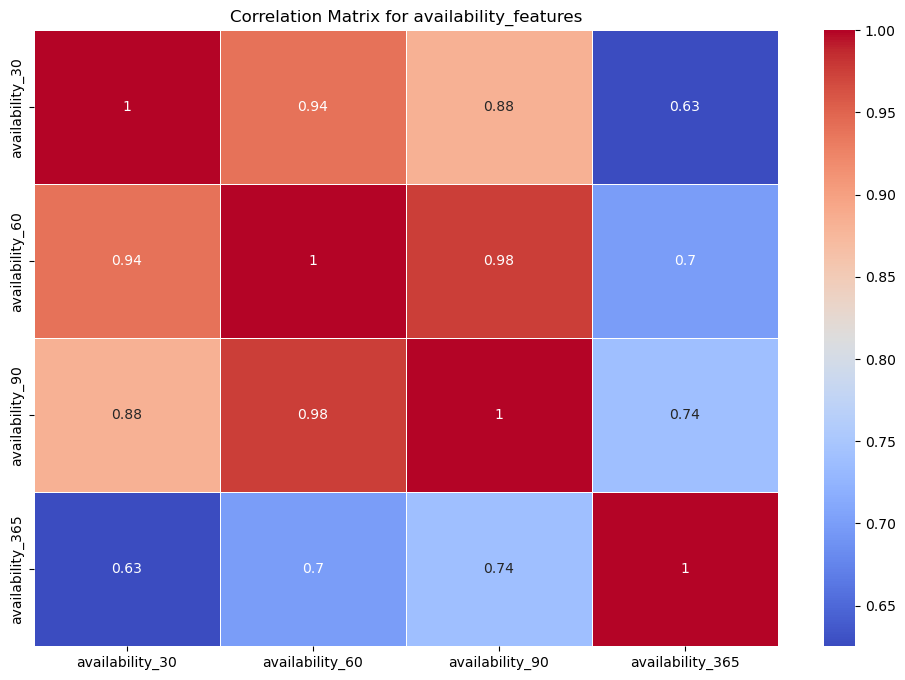

In [4]:
availability_features = ['availability_30', 'availability_60',
       'availability_90', 'availability_365']

corr_available_matrix = data[availability_features].corr()

# Heatmap generation.
plt.figure(figsize=(12, 8))
sns.heatmap(corr_available_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for availability_features')
plt.show()

# Feature Selection

### Will use some domain knowledge here and try to select the important features

In [5]:
# Remove columns with almost no values.
data.drop(columns=['bathrooms', 'neighbourhood_group_cleansed', 'calendar_updated', 'license'], inplace=True)

# Remove irrelevant columns, as these are not useful in my analysis.
data.drop(columns=['id', 'source', 'name', 'description', 'neighborhood_overview', 'host_since', 'host_location', 'host_acceptance_rate', 'host_neighbourhood', 'listing_url', 'scrape_id', 'last_scraped', 'picture_url', 'host_url', 'host_name', 'host_thumbnail_url', 'host_picture_url', 'host_about', 'property_type', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'neighbourhood',	'neighbourhood_cleansed', 'calendar_last_scraped', 'first_review', 'last_review'], inplace=True)

# Dropping below features as I'm more interested in availability_365 as per above heatmap, which shows strong coorelation among each others.
data.drop(columns=['availability_30', 'availability_60', 'availability_90'], inplace=True)

# Dropping below features as well, as I have considered review_scores_rating which represents the overall score of the listing.
data.drop(columns=['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'], inplace=True)

# I'm going to drop these features as I'll be considering only minimum_nights and maximum_nights features and I feel others are just redundant and will prove any importance in labelling and model prediction.
data.drop(columns=['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], inplace=True)


# Fill Missing Values

In [6]:
# Since now have our dataset ready with the columns we want, lets check if it has null values? if yes, we will have to handle them.

print(data.isnull().sum())

# We can see that they have null values.

# I'm going to calculate the percentage of missing values and based on the result I'm going to decide to drop or impute. Lets run the code to examine it.

null_values = {
    'host_response_time': 28918,
    'host_response_rate': 28918,
    'host_is_superhost': 932,
    'bathrooms_text': 103,
    'bedrooms': 32774,
    'beds': 1134,
    'review_scores_rating': 22158,
    'reviews_per_month': 22158
}

total_rows = 87946

# Calculate the percentage of missing values
missing_percentages = {}
for feature, null in null_values.items():
    missing_percentages[feature] = (null / total_rows) * 100

for feature, percentage in missing_percentages.items():
    print(f"{feature}: {percentage:.2f}% missing")

# Now we know the features that has more than 30% of null values. I'm going to drop that features except the bedroom one as that is important features in good/bad listing decision.
# I'll handle it separately.
data.drop(columns=['host_response_time', 'host_response_rate'], inplace=True)

# We can see that bedrooms also has more than 30% of missing values, I'm going to fill them using median(quantile) method as it's a generally a good approach.
# The median is a good measure of central tendency because it is not affected by outliers
data['bedrooms'].fillna(data['bedrooms'].median(), inplace=True)

# Now we have to handle the features which has missing values less than 30%.
# I'm going to handle them with mode, as they are categorical in nature and mode makes more sense and it will help in preserving the integrity and quality of your dataset for further analysis or modeling.
data['host_is_superhost'].fillna(data['host_is_superhost'].mode()[0], inplace=True)
data['host_identity_verified'].fillna(data['host_identity_verified'].mode()[0], inplace=True)
data['bathrooms_text'].fillna(data['bathrooms_text'].mode()[0], inplace=True)

# Again I'll use median here for below feature as its numerical in nature.
data['beds'].fillna(data['beds'].median(), inplace=True)


host_id                       0
host_response_time        28918
host_response_rate        28918
host_is_superhost           932
host_identity_verified        5
latitude                      0
longitude                     0
room_type                     0
accommodates                  0
bathrooms_text              103
bedrooms                  32774
beds                       1134
amenities                     0
price                         0
minimum_nights                0
maximum_nights                0
has_availability              0
availability_365              0
number_of_reviews             0
number_of_reviews_ltm         0
number_of_reviews_l30d        0
review_scores_rating      22158
instant_bookable              0
reviews_per_month         22158
dtype: int64
host_response_time: 32.88% missing
host_response_rate: 32.88% missing
host_is_superhost: 1.06% missing
bathrooms_text: 0.12% missing
bedrooms: 37.27% missing
beds: 1.29% missing
review_scores_rating: 25.20% missing
revi

# Use KNN

### KNN method to fill the review_scores_rating & reviews_per_month features as this features has some meaningful relationship with other features

In [7]:
# Now finally I'm going to use the KNN method to fill the review_scores_rating & reviews_per_month features as this features has some meaningful relationship with other features in the dataset.
# KNN imputation is a technique that uses the similarity between data points to fill in missing values. It works by finding the observations that are most similar to the one with the missing value, and then using the values of those observations to impute the missing value. 
# This can be an effective way to fill in missing values, especially when there are a lot of missing values.

# replace $ sign from price feature as I'm going to use this feature for KNN imputation.
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)

# I'm going to select relevant features for KNN imputation based on my domain knowledge.
knn_features = ['review_scores_rating', 'reviews_per_month', 'beds', 'accommodates', 'price', 'number_of_reviews']
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
data_imputed = knn_imputer.fit_transform(data[knn_features])
data_imputed = pd.DataFrame(data_imputed, columns=knn_features)
data['review_scores_rating'] = data_imputed['review_scores_rating']
data['reviews_per_month'] = data_imputed['reviews_per_month']

# Amazing, cooooool!!! we have now clean data as verified below.
print(data.isnull().sum())
data.info

host_id                   0
host_is_superhost         0
host_identity_verified    0
latitude                  0
longitude                 0
room_type                 0
accommodates              0
bathrooms_text            0
bedrooms                  0
beds                      0
amenities                 0
price                     0
minimum_nights            0
maximum_nights            0
has_availability          0
availability_365          0
number_of_reviews         0
number_of_reviews_ltm     0
number_of_reviews_l30d    0
review_scores_rating      0
instant_bookable          0
reviews_per_month         0
dtype: int64


<bound method DataFrame.info of          host_id host_is_superhost host_identity_verified   latitude  \
0         498201                 f                      t  51.442010   
1         499704                 f                      t  51.499930   
2          54730                 f                      t  51.568610   
3          60302                 f                      t  51.487800   
4         497514                 t                      t  51.476180   
...          ...               ...                    ...        ...   
87941  498408783                 t                      t  51.514860   
87942   36645347                 f                      t  51.459042   
87943  340514057                 f                      t  51.406100   
87944  439074505                 f                      t  51.450997   
87945  475112423                 f                      t  51.515970   

       longitude        room_type  accommodates    bathrooms_text  bedrooms  \
0      -0.187390     Pri

# Data Conversion

### Coverting the data to numerical values, which will be understable by model.

In [8]:
# Now we have the clean data, now its the time to convert some of the columns as they are not numerical and model will require everything in numerical.

# First converting boolean feature to 0/1.
data = pd.DataFrame(data)
data['host_is_superhost'] = data['host_is_superhost'].map({'t': 1, 'f': 0})
data['host_identity_verified'] = data['host_identity_verified'].map({'t': 1, 'f': 0})
data['instant_bookable'] = data['instant_bookable'].map({'t': 1, 'f': 0})
data['has_availability'] = data['has_availability'].map({'t': 1, 'f': 0})

# Some of the features have text data, we will have to use some kind of encoding techniques to convert the data, Let's handle them one by one.

# room_type, we are going to use the One-Hot encoding technique for it because it converts categorical variables into a format that can be provided to ML algorithms to do a better job in prediction.
# It creates binary columns for each category
data = pd.get_dummies(data, columns=['room_type'], drop_first=False, dtype='int')

# amenities, I'm going to count the number of amenities and put the numerical value here as I tried with both encoding techniques and found below:
# 1. One-Hot encoding gives a lot of features which I want to avoid.
# 2. Label encoding gives some random number which mis leads the data.
amenities_count = []
for amenities in data['amenities']:
    count = len(amenities.split(', '))
    amenities_count.append(count)

data['amenities_count'] = amenities_count

# Drop original columns as its not needed anymore.
data.drop(columns=['amenities'], inplace=True)

# bathroom_text, final feature for which I'm going to extract the numerical values and will create the binary column as well if the bathroom feature contains shared keyword.
data['bathrooms_count'] = data['bathrooms_text'].str.extract('(\d+(\.\d+)?)')[0].astype(float)
data['shared_bathroom'] = data['bathrooms_text'].str.contains('Shared', case=False, na=False).astype(int)

# After extraction, it has now introduced some blank values so I'm going to fill it with median.
data['bathrooms_count'].fillna(data['bathrooms_count'].median(), inplace=True)

# Drop original columns as its not needed anymore.
data.drop(columns=['bathrooms_text'], inplace=True)

print(data.isnull().sum())
data.info

# Wohooooooo, now we have complete data with all numerical values.


host_id                      0
host_is_superhost            0
host_identity_verified       0
latitude                     0
longitude                    0
accommodates                 0
bedrooms                     0
beds                         0
price                        0
minimum_nights               0
maximum_nights               0
has_availability             0
availability_365             0
number_of_reviews            0
number_of_reviews_ltm        0
number_of_reviews_l30d       0
review_scores_rating         0
instant_bookable             0
reviews_per_month            0
room_type_Entire home/apt    0
room_type_Hotel room         0
room_type_Private room       0
room_type_Shared room        0
amenities_count              0
bathrooms_count              0
shared_bathroom              0
dtype: int64


<bound method DataFrame.info of          host_id  host_is_superhost  host_identity_verified   latitude  \
0         498201                  0                       1  51.442010   
1         499704                  0                       1  51.499930   
2          54730                  0                       1  51.568610   
3          60302                  0                       1  51.487800   
4         497514                  1                       1  51.476180   
...          ...                ...                     ...        ...   
87941  498408783                  1                       1  51.514860   
87942   36645347                  0                       1  51.459042   
87943  340514057                  0                       1  51.406100   
87944  439074505                  0                       1  51.450997   
87945  475112423                  0                       1  51.515970   

       longitude  accommodates  bedrooms  beds  price  minimum_nights  ...  \
0

# Feature Engineering

### Create super feature based on existing feature for manual labelling of good/bad listing

#### I want to create the new feature distance_to_central_london which says 0/1 based on the distance from central london

In [9]:
# Since location also plays important role in listing the property as good/bad, so I'm going to create the new feature called close/not close.
# This new feature will tell us how much the property is closer to London city center, and then also convert it to numerical.
# We will have to use the formulae called haversine, Let's do it.

central_london_lat = 51.52
central_london_lon = -0.127

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

distances = []
for i in range(len(data)):
    lat = data.loc[i, 'latitude']
    lon = data.loc[i, 'longitude']
    distance = haversine(lat, lon, central_london_lat, central_london_lon)
    distances.append(distance)

data['distance_to_central_london'] = distances

# Define a threshold distance in kilometers, I'll choose 5 kms.
threshold_distance = 5

close_to_central_london = []
for distance in data['distance_to_central_london']:
    if distance <= threshold_distance:
        close_to_central_london.append(1)
    else:
        close_to_central_london.append(0)

data['close_to_central_london'] = close_to_central_london

# Droping the distance_to_central_london column as its not needed anymore.
data.drop(columns=['distance_to_central_london'], inplace=True)

print(data.isnull().sum())
data.info

host_id                      0
host_is_superhost            0
host_identity_verified       0
latitude                     0
longitude                    0
accommodates                 0
bedrooms                     0
beds                         0
price                        0
minimum_nights               0
maximum_nights               0
has_availability             0
availability_365             0
number_of_reviews            0
number_of_reviews_ltm        0
number_of_reviews_l30d       0
review_scores_rating         0
instant_bookable             0
reviews_per_month            0
room_type_Entire home/apt    0
room_type_Hotel room         0
room_type_Private room       0
room_type_Shared room        0
amenities_count              0
bathrooms_count              0
shared_bathroom              0
close_to_central_london      0
dtype: int64


<bound method DataFrame.info of          host_id  host_is_superhost  host_identity_verified   latitude  \
0         498201                  0                       1  51.442010   
1         499704                  0                       1  51.499930   
2          54730                  0                       1  51.568610   
3          60302                  0                       1  51.487800   
4         497514                  1                       1  51.476180   
...          ...                ...                     ...        ...   
87941  498408783                  1                       1  51.514860   
87942   36645347                  0                       1  51.459042   
87943  340514057                  0                       1  51.406100   
87944  439074505                  0                       1  51.450997   
87945  475112423                  0                       1  51.515970   

       longitude  accommodates  bedrooms  beds  price  minimum_nights  ...  \
0

# Manual Labelling Good/Bad

### Manual labelling of the data, to determine if the listing can be categorized as good or bad.

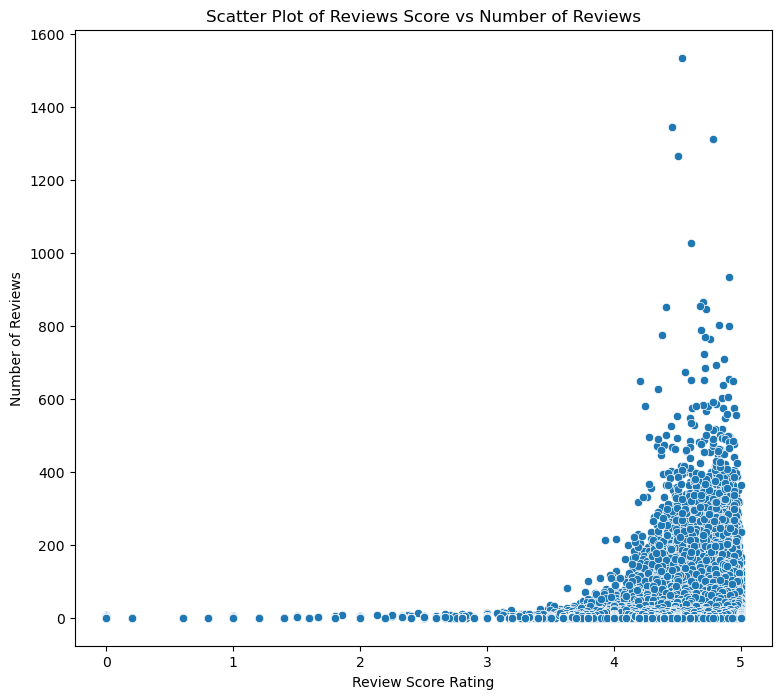

Good listings: 21021
Bad listings: 66925
host_id                      0
host_is_superhost            0
host_identity_verified       0
latitude                     0
longitude                    0
accommodates                 0
bedrooms                     0
beds                         0
price                        0
minimum_nights               0
maximum_nights               0
has_availability             0
availability_365             0
number_of_reviews            0
number_of_reviews_ltm        0
number_of_reviews_l30d       0
review_scores_rating         0
instant_bookable             0
reviews_per_month            0
room_type_Entire home/apt    0
room_type_Hotel room         0
room_type_Private room       0
room_type_Shared room        0
amenities_count              0
bathrooms_count              0
shared_bathroom              0
close_to_central_london      0
target_feature               0
dtype: int64


<bound method DataFrame.info of          host_id  host_is_superhost  host_identity_verified   latitude  \
0         498201                  0                       1  51.442010   
1         499704                  0                       1  51.499930   
2          54730                  0                       1  51.568610   
3          60302                  0                       1  51.487800   
4         497514                  1                       1  51.476180   
...          ...                ...                     ...        ...   
87941  498408783                  1                       1  51.514860   
87942   36645347                  0                       1  51.459042   
87943  340514057                  0                       1  51.406100   
87944  439074505                  0                       1  51.450997   
87945  475112423                  0                       1  51.515970   

       longitude  accommodates  bedrooms  beds  price  minimum_nights  ...  \
0

In [10]:
# Based on below visualization, I can clearly see that number of reviews are increasing proportionally to review score rating.
# Thats the reason I'm going to set the review score threshold to 4 and number of reviews to more than or equal to 1 (as new listings will have lesser reviews).
# I'm going to use both features in my manual good/bad labelling.
plt.figure(figsize=(9, 8))
sns.scatterplot(x='review_scores_rating', y='number_of_reviews', data=data)
plt.title('Scatter Plot of Reviews Score vs Number of Reviews')
plt.xlabel('Review Score Rating')
plt.ylabel('Number of Reviews')
plt.show()

# Also I have chosen new super feature, which is created from lat/long to determine manual labelling. Based on my domain knowledge, location is preferred over price when chosing the property.
price_threshold = data['price'].mean()
review_scores_rating = 4
number_of_reviews = 1
close_to_central_london = 1

# Creating a new column for getting good and bad based on threshold
data['target_feature'] = np.where(
    (data['close_to_central_london'] >= close_to_central_london) &
    (data['number_of_reviews'] >= number_of_reviews) &
    (data['review_scores_rating'] > review_scores_rating),
    'Good',
    'Bad'
)

good_count = data['target_feature'].value_counts()['Good']
bad_count = data['target_feature'].value_counts()['Bad']

print(f"Good listings: {good_count}")
print(f"Bad listings: {bad_count}")

# Since the target_column is good/bad we will need to convert it to numerical again for training the model.
data['target_feature'] = data['target_feature'].map({'Good': 1, 'Bad': 0})

# Check one more time to see if there any nulls or suprises?
print(data.isnull().sum())
data.info

# Model Training with Logistics Regression

### Using the log regression model to train and evalute the results

In [11]:
# Ok, so now we have our clean and converted data available. I'm going to run the logistics regression model on this data and evaluate it.
# I'll also ignore the features used in my manual labelling to avoid bias in the model.

# Also I'll try with both Logistics Regression as well as Random Forest Algorithm.

# Ignoring the features used in manual labeling.
features_to_ignore = ['close_to_central_london', 'number_of_reviews', 'review_scores_rating', 'target_feature']
X = data.drop(columns=features_to_ignore)
y = data['target_feature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lm_model = LogisticRegression()
lm_model.fit(X_train, y_train)

y_pred = lm_model.predict(X_test)

# Print the classification report.
print(classification_report(y_test, y_pred))

# Print the confusion matrix.
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Perform k-fold cross-validation with the lg model.
cv_scores = cross_val_score(lm_model, X, y, cv=5, scoring='accuracy')
print(f"kfold-cross-validation scores: {cv_scores}")

              precision    recall  f1-score   support

           0       0.78      0.97      0.86     13497
           1       0.48      0.08      0.14      4093

    accuracy                           0.77     17590
   macro avg       0.63      0.53      0.50     17590
weighted avg       0.71      0.77      0.70     17590

Confusion Matrix:
[[13138   359]
 [ 3755   338]]
kfold-cross-validation scores: [0.76094372 0.76098698 0.76098698 0.76098698 0.76098698]


# Model Training with Random Forest

### Using the random forest model to train and evalute the results

In [13]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print the classification report.
print(classification_report(y_test, y_pred))

# Print the confusion matrix.
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Perform k-fold cross-validation with the rf model.
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"kfold-cross-validation scores: {cv_scores}")

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     13497
           1       0.86      0.83      0.85      4093

    accuracy                           0.93     17590
   macro avg       0.90      0.90      0.90     17590
weighted avg       0.93      0.93      0.93     17590

Confusion Matrix:
[[12924   573]
 [  679  3414]]
kfold-cross-validation scores: [0.90324048 0.90852237 0.90408778 0.93285576 0.88765706]


# Final Verdicts from both Models.

### What does Precision, F1, and Recall says about my modelling.

## 1. Logistics Regression Results

                precision    recall  f1-score   support

           0       0.78      0.97      0.86     13497
           1       0.48      0.08      0.14      4093


#### For 0s
Precision is 0.78 shows good prediction accuracy of 0s, with correct predictions of 78%.
Recall is 0.97, which shows from actual value that 97% were correctly identified.

F1 score is 0.86 which shows good balance between the Precision and Recall.

#### For 1s
Precision is 0.48 shows prediction accuracy of 1s, with correct predictions of 48%.
Recall is 0.08, which shows from actual value that only 8% were correctly identified.

F1 score is 0.14 which shows `POOR` performance of my modelling with this algorithm.

#### Accuracy
77% overall.

### Final Inference
The model performs well for bad listings but poorly for good listings.



## 2. Random Forest Results

               precision    recall  f1-score   support

           0       0.95      0.96      0.95     13497
           1       0.86      0.83      0.85      4093

#### For 0s
Precision is 0.95 shows good prediction accuracy of 0s, with correct predictions of 95%.
Recall is 0.96, which shows from actual value that 96% were correctly identified.

F1 score is 0.95 which shows good balance between the Precision and Recall.

#### For 1s
Precision is 0.86 shows prediction accuracy of 1s, with correct predictions of 86%.
Recall is 0.83, which shows from actual value that 83% were correctly identified.

F1 score is 0.85 which shows `GOOD` performance of my modelling with this algorithm.

#### Accuracy
93% overall.

### Final Inference
Overall the random forest algorithm performs very well, for both Good and Bad listings prediction as evident from Precision, F1 and Recall numbers.



# Random Forest Algorithm stands out for me, and hence declared as efficient model in my use case and work throughout!